# Custom Multi-Qubit Delay Cross-Talk Error Simulator Backend

This notebook adds a customized `DelayAerSimulator` backend that extends the `AerSimulator` to support simulation of parameterized delay noise in scheduled circuits.

## Motivation

Recently, the ability to schedule circuits was added to qiskit to reason about duration and timing of instructions in circuits.  This process adds delay gates into a circuit when a qubit is idle.  For accurate noisy simulations, qubits should have cross-talk noise when multiple connected qubits are in a delay.

The current way noise is implemented adds noise based purely on each gate without consideration of other qubits/delays.  This notebook provides a way to add cross-talk errors that depend on duration to the noise model.  These errors are the most prevalent type of error because they show up with Delays, which are a prolific part of every circuit.

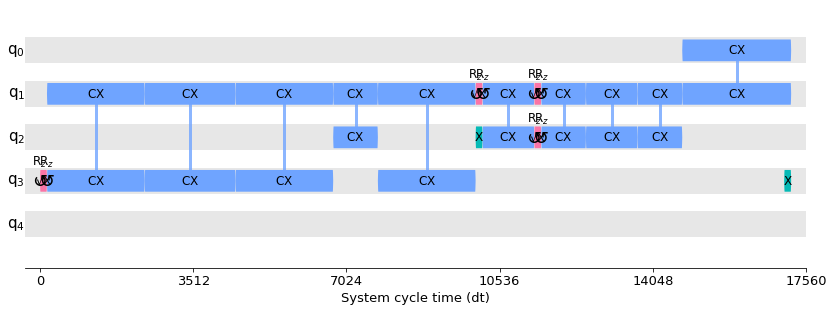

In [1]:
from qiskit.visualization.timeline import draw
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo

# Simulator backend
_delay_ex_backend = FakeVigo()

# Make a cirucit
_qc = QuantumCircuit(4)
_qc.h(0)
_qc.cx(0, 1)
_qc.x(1)
_qc.cx(0, 2)
_qc.x(2)
_qc.cz(1, 0)
_qc.h(1)
_qc.cx(1, 3)

# Schedule
_sched_circ = transpile(_qc, _delay_ex_backend, scheduling_method='alap')
draw(_sched_circ)

In [2]:
_sched_circ.draw(fold=-1)

┌──────────────────┐                                                                                                                                                                      ┌───┐       
      q_3 -> 0 ┤ DELAY(14720[dt]) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────
               └┬────────────────┬┘                      ┌───┐                                                    ┌─────────┐    ┌────┐┌─────────┐┌───┐┌─────────┐┌────┐┌─────────┐     ┌───┐            └─┬─┘       
      q_2 -> 1 ─┤ DELAY(160[dt]) ├────────────────────■──┤ X ├──■───────────■──────────────────────────────■──────┤ RZ(π/2) ├────┤ √X ├┤ RZ(π/2) ├┤ X ├┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├──■──┤ X ├──■───────────■─────────
               ┌┴────────────────┤                    │  └─┬─┘  │         ┌─┴─┐       ┌─────────────────┐  │      └──┬───┬──┘    └────┘└─────────┘└─┬─┘├─────────┤├────┤├─────────┤┌─┴─┐└─┬─┘┌─┴─┐┌─────────────────┐
      q_1 -> 2 ┤ DELAY(6720[dt]) ├────────────────────┼────┼────┼─────────┤ X ├───────┤ DELAY(2240[dt]) ├──┼─────────┤ X ├──────────────────────────■──┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├┤ X ├──■──┤ X ├┤ DELAY(2496[dt]) ├
               └───┬─────────┬───┘ ┌────┐┌─────────┐┌─┴─┐  │  ┌─┴─┐┌──────┴───┴──────┐└─────────────────┘┌─┴─┐┌──────┴───┴──────┐┌───┐                 └─────────┘└────┘└─────────┘└───┘     └───┘└─────────────────┘
      q_0 -> 3 ────┤ RZ(π/2) ├─────┤ √X ├┤ RZ(π/2) ├┤ X ├──■──┤ X ├┤ DELAY(1024[dt]) ├───────────────────┤ X ├┤ DELAY(7072[dt]) ├┤ X ├───────────────────────────────────────────────────────────────────────────────
               ┌───┴─────────┴────┐└────┘└─────────┘└───┘     └───┘└─────────────────┘                   └───┘└─────────────────┘└───┘                                                                               
ancilla_0 -> 4 ┤ DELAY(17216[dt]) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               └──────────────────┘

## Implementation

The from_backend function allows this custom simulator to run an additional pass after the circuit has been transpiled.  During this pass, analysis data regarding the delays and duration of the delays is added to the circuit metadata.  This pass then adds a custom label to each delay gate to specify the duration of the delay.  After the pass finishes running, a post processing step is applied which takes each custom label and adds a thermal relaxation error to the noise model in the given simulator based on the length of the delay given in the circuit metadata.

todo:: expand^
via transpilation pass that does it via noise model

## Simulation

To simulate parameterized delay errors with this backend:

1. The backend must contain a properties that includes T1, T2, and gate durations for all gates in the basis gates.
1. The simulator `cross_talk_noise` option must be set to `True` (this defaults to True if simulator is constructed using `DelayAerSimulator.from_backend`)
2. The input circuits must contain delay instructions to add errors to (eg be scheduled using `transpile(circuits, backend, scheduling_method=val)`)


### Example:
```python
# Device noise simulator
simulator = DelayAerSimulator.from_backend(real_backend)

# Schedule circuits
scheduled_circuits = transpile(circuits, simulator, scheduling_method='alap')

# Run
result = simulator.run(scheduled_circuits).result()
```

In [3]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit
import copy
from delayPasses.crossTalkPass import CrossTalkDelayReplace

class DelayAerSimulator(AerSimulator):
    # Override methods of AerSimulator to add support for automatically
    # extending the noise model with errors for the parameterized gates

    @classmethod
    def _default_options(cls):
        # Add delay option defaulting to false
        opts = AerSimulator._default_options()
        opts.cross_talk_noise = False
        opts.theta = 0.1
        return opts

    @classmethod
    def from_backend(cls, backend, **options):
        """Initialize simulator from backend."""

        # Add delay noise option
        if 'cross_talk_noise' not in options:
            options['cross_talk_noise'] = True
        
        # Add theta specification option
        if 'theta' not in options:
            options['theta'] = 0.1

        # Get configuration and properties from backend
        configuration = copy.copy(backend.configuration())
        properties = copy.copy(backend.properties())

        # Customize configuration name
        name = configuration.backend_name
        configuration.backend_name = 'aer_simulator({})'.format(name)

        # Use automatic noise model if none is provided
        if 'noise_model' not in options:
            noise_model = NoiseModel.from_backend(backend)
            if not noise_model.is_ideal():
                options['noise_model'] = noise_model

        # Initialize simulator
        sim = cls(configuration=configuration,
                  properties=properties,
                  **options)
        return sim
    
    # pylint: disable=arguments-differ
    def run(self, circuits, validate=False, **run_options):
        
        # Pre-process parameterized error options
        options = copy.deepcopy(run_options)
        if 'cross_talk_noise' in options:
            cross_talk_noise = options.pop('cross_talk_noise')
        else:
            cross_talk_noise = self.options.cross_talk_noise
        if 'noise_model' in options:
            noise_model = options.pop('noise_model')
        else:
            noise_model = self.options.noise_model
        if 'theta' in options:
            theta = options.pop('theta')
        else:
            theta = self.options.theta
        

        if noise_model is not None: noise_model.add_basis_gates(RZZGate(theta=theta))
        # Add delay noise scheduling
        if cross_talk_noise:
            # Run custom transpiler pass to replace delays
            pm = PassManager()
            pm.append([CrossTalkDelayReplace(super().configuration().coupling_map, theta)])
            circuits = pm.run(circuits)
            print("Noise model: ", noise_model)
            
        # Run noisy simulation
        return super().run(circuits, validate=validate, noise_model=noise_model, **options)

### Example 1: Verification of the cross talk backend

To validate that the backend does change the counts (after making sure you have a sufficiently complicated circuit -- both of the provided options will do), you can set "cross_talk_noise=False" when from_backend() is called below.

In [4]:
##Test circuit
from qiskit import QuantumCircuit

def test_circuit(num_qubits, measure=True, repeat=0):
    """Generate a GHZ circuit on N-qubits
    
    The ``repeat`` will pairs of self-inverse gates to
    pad the circuit to be of longer duration
    """
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for _ in range(repeat):
        qc.barrier(0)
        qc.h(0)
        qc.barrier(0)
        qc.h(0)
        qc.barrier(0)
    for i in range(1, num_qubits):
        qc.cx(0, i)
        for _ in range(repeat):
            qc.barrier([0, i])
            qc.cx(0, i)
            qc.barrier([0, i])
            qc.cx(0, i)
            qc.barrier([0, i])
    if measure:
        qc.measure_all()
    return qc
            
test_circuit(3, repeat=1).draw(fold=-1)

┌───┐ ░ ┌───┐ ░ ┌───┐ ░       ░       ░       ░       ░       ░       ░  ░ ┌─┐      
   q_0: ┤ H ├─░─┤ H ├─░─┤ H ├─░───■───░───■───░───■───░───■───░───■───░───■───░──░─┤M├──────
        └───┘ ░ └───┘ ░ └───┘ ░ ┌─┴─┐ ░ ┌─┴─┐ ░ ┌─┴─┐ ░   │   ░   │   ░   │   ░  ░ └╥┘┌─┐   
   q_1: ────────────────────────┤ X ├─░─┤ X ├─░─┤ X ├─░───┼───────┼───────┼──────░──╫─┤M├───
                                └───┘ ░ └───┘ ░ └───┘ ░ ┌─┴─┐ ░ ┌─┴─┐ ░ ┌─┴─┐ ░  ░  ║ └╥┘┌─┐
   q_2: ────────────────────────────────────────────────┤ X ├─░─┤ X ├─░─┤ X ├─░──░──╫──╫─┤M├
                                                        └───┘ ░ └───┘ ░ └───┘ ░  ░  ║  ║ └╥┘
meas: 3/════════════════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                                    0  1  2

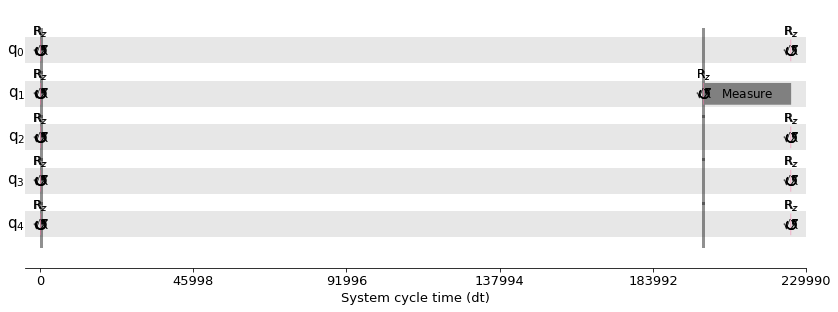

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo

# Simulator backend
target_backend = FakeVigo()
backend = DelayAerSimulator.from_backend(target_backend,
                                         noise_model=None,
#                                          cross_talk_noise=False,
                                        )
properties = backend.properties()

#Make a cirucit
##opt1: simple GHZ state
# qc = QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.cx(0, 2)

delays = range(2000, 200000, 1000)
for delay in delays:
    qc = QuantumCircuit(5, 1)
    qc.h(range(5))
    qc.barrier(range(5))
    qc.delay(delay, range(5))
    qc.barrier(range(5))
    qc.h(range(5))
    qc.measure(1, 0)

##opt2: complicated mess
# qc = QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.x(1)
# qc.cx(0, 2)
# qc.x(2)
# qc.cz(1, 0)
# qc.h(1)
# qc.cx(1, 3)
# qc.measure_all()
# qc = test_circuit(4, repeat=2)

# Schedule
sched_circ = transpile(qc, backend, scheduling_method='alap')
draw(sched_circ)

In [6]:
sched_circ.draw(fold=-1)

┌─────────┐┌────┐┌─────────┐ ░ ┌─────────────────────┐ ░ ┌──────────────────┐┌─────────┐   ┌────┐  ┌─────────┐   
q_0 -> 0 ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1.99e+05[dt]) ├─░─┤ DELAY(26160[dt]) ├┤ RZ(π/2) ├───┤ √X ├──┤ RZ(π/2) ├───
         ├─────────┤├────┤├─────────┤ ░ ├─────────────────────┤ ░ └───┬─────────┬────┘└──┬────┬─┘┌──┴────┴─┐└─────────┘┌─┐
q_1 -> 1 ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1.99e+05[dt]) ├─░─────┤ RZ(π/2) ├────────┤ √X ├──┤ RZ(π/2) ├───────────┤M├
         ├─────────┤├────┤├─────────┤ ░ ├─────────────────────┤ ░ ┌───┴─────────┴────┐┌──┴────┴─┐└──┬────┬─┘┌─────────┐└╥┘
q_2 -> 2 ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1.99e+05[dt]) ├─░─┤ DELAY(26160[dt]) ├┤ RZ(π/2) ├───┤ √X ├──┤ RZ(π/2) ├─╫─
         ├─────────┤├────┤├─────────┤ ░ ├─────────────────────┤ ░ ├──────────────────┤├─────────┤   ├────┤  ├─────────┤ ║ 
q_3 -> 3 ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1.99e+05[dt]) ├─░─┤ DELAY(26160[dt]) ├┤ RZ(π/2) ├───┤ √X ├──┤ RZ(π/2) ├─╫─
         ├─────────┤├────┤├─────────┤ ░ ├─────────────────────┤ ░ ├──────────────────┤├─────────┤   ├────┤  ├─────────┤ ║ 
q_4 -> 4 ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ DELAY(1.99e+05[dt]) ├─░─┤ DELAY(26160[dt]) ├┤ RZ(π/2) ├───┤ √X ├──┤ RZ(π/2) ├─╫─
         └─────────┘└────┘└─────────┘ ░ └─────────────────────┘ ░ └──────────────────┘└─────────┘   └────┘  └─────────┘ ║ 
    c: 1/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═
                                                                                                                        0

### Verification via histogram
The following histogram is a plot of a "noisy" typical simulator run of FakeVigo as well as the modified custom backend I provide WITHOUT a noise model (ie. the only noise present is the noise caused by crosstalk).

The "ideal" simulation should show typical circuit noise caused by the simulator's noise model.  The "noisy" simulation should only show noise added by the crosstalk pass (as the noise model is set to None).  Both simulations use the same base backend simulator.

Noise model:  None


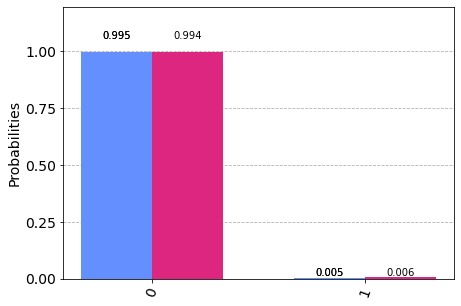

In [7]:
from qiskit.visualization import plot_histogram

# Run using custom backend
shots = 10000
result_noise = backend.run([sched_circ], shots=shots).result()
counts_noise = result_noise.get_counts(0)
##Note: if the circuit is sufficiently complicated, you should see a majority of correct counts
## plus a few scattered incorrect (error) counts
# result.get_counts(0)

#ideal
sim_ideal = FakeVigo()

result_ideal = sim_ideal.run([sched_circ], shots=shots).result()
counts_ideal = result_ideal.get_counts(0)

plot_histogram([counts_ideal, counts_noise])

In [9]:
from qiskit.circuit.library import RZZGate
#At this point, this is facetious, but I like the way it looks :)
RZZGate(0.1).decompositions[0].draw()

q_0: ──■─────────────────────────────■──
     ┌─┴─┐┌───────────────────────┐┌─┴─┐
q_1: ┤ X ├┤ RZ(0.100000000000000) ├┤ X ├
     └───┘└───────────────────────┘└───┘